In [1]:
# This is the clean notebook. Only code that is necessary for everything to work is included here. 
# Everything else can still be found in the 'Preliminary Notebook'

In [2]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 99

In [3]:
# The tables I pulled from pro-football-reference.com had week-by-week records in them, but excel forcibly parsed them
# as dates. Hence, this function. It takes the weekly win/loss result infromation from the existing dataframe
# and creates two new columns 'W' and 'L' containing win and loss totals for the season to that point. 

def record_generator(old_df):
    wins = [0]
    losses = [0]
    for i in old_df.Result:
        if i == 'W':
            wins.append(wins[-1] + 1)
            losses.append(losses[-1])
        elif i == 'L':
            wins.append(wins[-1])
            losses.append(losses[-1] + 1)
        else:    
            wins.append(wins[-1])
            losses.append(losses[-1])
    winloss = pd.DataFrame(np.array([wins[1:], losses[1:]]).T, columns = ['W', 'L'])  
    new_df = pd.concat([old_df, winloss], axis=1).set_index("Week")
    return new_df
    

In [4]:
# My list of teams. All abbreviations are based on the team's name and location as of 2018.
# That bit of information will become important later. 

teams = ['nyj', 'nep', 'mia', 'buf', 'pit', 'bal', 'cle', 'cin', 'ind', 'jax', 'ten', 'hou', 'lac', 'oak', 'kcc', 'den',\
        'nyg', 'phi', 'was', 'dal', 'min', 'gbp', 'det', 'chi', 'tbb', 'atl', 'nos', 'car', 'lar', 'sea', 'ari', 'sff']

In [5]:
# I initially pulled data going back to 2002, which is when the last expansion team joined the league 
# and the divisions and playoff structure took on their current format. 

seasons = [str(i) for i in range(2002, 2018)]



# The early seasons list was made after I realized I needed more draft data. 
# 1990 was when the playoffs took on (roughly) their current format, 
# although there were fewer teams and the divisions were different. 

early_seasons = [str(i) for i in range(1990, 2002)]



# More additions. 1978 is when the 16-game schedule was adopted, as exists today. 

earlier_seasons = [str(i) for i in range(1978, 1990)]

In [6]:
# Combining the lists of seasons. 
all_seasons = earlier_seasons + early_seasons + seasons

In [7]:
# Creating a nested dictionary of the season-team dataframes. 
# Each key in the dictionary is a season, whose value is itself a dictionary. 
# Each key in those sub-dictionaries is a season-team (for example the 1989 Broncos), 
# and the values are the dataframes mentioned above. 

full_dict = {}

for season in seasons:
    full_dict[season] = {team: record_generator(pd.read_csv('../Datasets/{}/{}{}.csv'\
                        .format(season, team.upper(), season),names=['Week', 'Result']).fillna('Bye')) for team in teams}

In [8]:
# I downloaded tables containing final standings (and some other information) from each season from pro-football-reference. 
# Each table was only for one conference, though (for example, 2004 AFC standings and NFC standings were separate tables).
# Not all the tables are of exactly the same format, but for the purposes of this project it didn't matter. 


# Playoff_dict is also a nested dictionary. 
# Each key is a season, whose value is itself a dictionary. 
# Each key in those sub-dictionaries is a season-conference (for example, 2008 NFC),
# and the values are the final standings (along with some other information). 

playoff_dict = {}
for season in seasons[1:]:   # This includes 2003-2017. See below. 
    playoff_dict[season] = {conference: pd.read_csv('../Datasets/Playoff_Standings/{}{}.csv'.format(conference, season))\
                            for conference in ['AFC', 'NFC']}

# Pro-Football-Reference did not have a tables for the 2002 playoff standings so I had to make them myself. 
playoff_dict['2002'] = {}
playoff_dict['2002']['AFC'] = pd.DataFrame([['OAK', 11, 5, 0, 'West Champion', np.NaN],\
                                           ['TEN', 11, 5, 0, 'South Champion', np.NaN],\
                                           ['PIT', 10, 5, 1, 'North Champion', np.NaN],\
                                           ['NYJ', 9, 7, 0, 'East Champion', np.NaN],\
                                           ['IND', 10, 6, 0, 'Wild Card #1', np.NaN],\
                                           ['CLE', 9, 7, 0, 'Wild Card #2', np.NaN]],\
                                           columns=['Tm', 'W', 'L', 'T', 'Position', 'Reason'])

playoff_dict['2002']['NFC'] = pd.DataFrame([['TBB', 12, 4, 0,  'South Champion', np.NaN],\
                                           ['PHI', 12, 4, 0, 'East Champion', np.NaN],\
                                           ['GBP', 12, 4, 0, 'North Champion', np.NaN],\
                                          ['SFF', 10, 6, 0, 'West Champion', np.NaN],\
                                          ['NYG', 10, 6, 0, 'Wild Card #1', np.NaN],\
                                            ['ATL', 9, 6, 1, 'Wild Card #2', np.NaN]],\
                                          columns=['Tm', 'W', 'L', 'T', 'Position', 'Reason'])

In [9]:
# Added this when I went back to 1990. 

for season in early_seasons:
    playoff_dict[season] = {conference: pd.read_excel('../Datasets/Playoff_Standings/{}{}.xlsx'\
                            .format(conference, season))\
                            for conference in ['AFC', 'NFC']}

In [10]:
# And this when I went back to 1978.

for season in earlier_seasons:
    playoff_dict[season] = {conference: pd.read_excel('../Datasets/Playoff_Standings/{}{}.xlsx'\
                            .format(conference, season))\
                            for conference in ['AFC', 'NFC']}
    

In [11]:
# I downloaded (from pro-football-reference) tables containing all the NFL draft information going back to 1978.
# Each table contained the data for one year's draft. 
# Although the information from the entire draft (7 rounds) was included, I only downloaded the parts of the tables
# that contained the first round of each draft. 



#By this point I had realized that pd.read_excel was a thing. 
draft_dict = {}
for season in seasons:
    draft_dict[season] = pd.read_excel('../Datasets/Drafts/Draft{}.xlsx'\
                                       .format(season), header=1, skiprows=[2]).set_index('Pick')

# Adding in entries for the early seasons    
for season in early_seasons: 
    draft_dict[season] = pd.read_excel('../Datasets/Drafts/Draft{}.xlsx'\
                                       .format(season), header=1, skiprows=[2]).set_index('Pick')  

# Adding in entries for earlier seasons.     
for season in earlier_seasons:
    draft_dict[season] = pd.read_excel('../Datasets/Drafts/Draft{}.xlsx'\
                                       .format(season), header=1, skiprows=[2]).set_index('Pick') 
    

After some tedious data cleaning (which can be found in the other notebook) ...

In [13]:
# I still had a problem. The team names were recorded as abbreviations in some of the tables, 
# while others contained the full names. Some of the abbreviations were different from the ones I chose (see 'teams' list above).
# And some teams had moved or changed there names. Hence the need for this function. 


def team_abbreviator(x):
    if x == 'NWE' or 'New England Patriots' in x:
        return 'NEP'
    elif 'New York Jets' in x:
        return 'NYJ'
    elif 'Miami Dolphins' in x:
        return 'MIA'
    elif 'Buffalo Bills' in x:
        return 'BUF'
    elif 'Pittsburgh Steelers' in x:
        return 'PIT'
    elif 'Baltimore Ravens' in x:
        return 'BAL'
    elif 'Bengals' in x:
        return 'CIN'
    elif 'Browns' in x:
        return 'CLE'
    elif 'Colts' in x:
        return 'IND'
    elif 'Titans' in x or 'Oilers' in x:    # The Tennessee Titans were the Houston Oilers until 1996, and were still 
        return 'TEN'                        # called the Tennessee Oilers until 1998. 
    elif 'Texans' in x:
        return 'HOU'
    elif 'Jaguars' in x:
        return 'JAX'
    elif 'Broncos' in x:
        return 'DEN'
    elif x == 'KAN' or 'Chiefs' in x:
        return 'KCC'
    elif x=='RAI' or 'Raiders' in x:
        return 'OAK'
    elif x == 'SDG' or 'Chargers' in x:     
        return 'LAC'
    elif 'Giants' in x:
        return 'NYG'
    elif 'Eagles' in x:
        return 'PHI'
    elif 'Cowboys' in x:
        return 'DAL'
    elif 'Redskins' in x: 
        return 'WAS'
    elif 'Bears' in x:
        return 'CHI'
    elif 'Vikings' in x:
        return 'MIN'
    elif 'Lions' in x:
        return 'DET'
    elif x == 'GNB' or 'Packers' in x:
        return 'GBP'
    elif x == 'TAM' or 'Buccaneers' in x:
        return 'TBB'
    elif 'Falcons' in x:
        return 'ATL'
    elif x=='NOR' or 'Saints' in x:
        return 'NOS'
    elif 'Panthers' in x:
        return 'CAR'
    elif 'Seahawks' in x:
        return 'SEA'
    elif x == 'SFO' or 'San Francisco' in x:
        return 'SFF'
    elif x=='PHO' or 'Cardinals' in x:
        return 'ARI'
    elif x == 'STL' or x == 'RAM' or 'Rams' in x:   # This line presents a problem for the St. Louis Cardinals (1960-1987)
        return 'LAR'
    else:
        return x

    
# The problems this function did not (and could not) solve will be dealt with below. 

In [14]:
# Accounting for Cleveland '95. 
# After the 1995 season, the Cleveland Browns moved to Baltimore and became the Ravens. 
# A new Cleveland Browns franchise sprung up in 1999. 
# Officially, the NFL considered the Baltimore Ravens a new franchise and the new Cleveland Browns 
# a continuation of the old Browns. However, for analysis purposes, it makes far more sense to consider 
# the Ravens the same franchise as the old Browns and the new Browns as the new franchise, in accordance 
# with the reality on the ground. 

# This cell must be run before the team_abbreviator function is applied, because otherwise, 'Cleveland Browns'
# will simply be rendered as 'CLE'.

for season in range(1978, 1996):
    playoff_dict[str(season)]['AFC']['Tm'] = playoff_dict[str(season)]['AFC']['Tm'].apply(lambda x: 'BAL' if 'Cleveland' in x else x)

In [15]:
# Now that the issue has been corrected, the team_abbreviator function can be applied. 

for season in playoff_dict:
    for conference in ['AFC', 'NFC']:
        playoff_dict[season][conference]['Tm'] = playoff_dict[season][conference]['Tm'].apply(team_abbreviator)
        

The playoff_dict is in order. Now it's time to fix up the draft_dict. 

In [16]:
# Accounting for 'BAL' being the Colts until 1983.

# The Baltimore Colts moved to Indianapolis after the 1983 season, 
# but this did not cause a problem in the playoff_dict because those tables contained the full team names. 
# The draft tables, however, contained only abbreviations. 

for season in range(1978, 1984):
    draft_dict[str(season)].Tm = draft_dict[str(season)].Tm.apply(lambda x: 'IND' if x == 'BAL' else x)

In [17]:
# Accounting for Cleveland '95. (see above)

for season in range(1978, 1996):
    draft_dict[str(season)].Tm = draft_dict[str(season)].Tm.apply(lambda x: 'BAL' if x == 'CLE' else x)

In [18]:
# Accounting for the Houston Oilers' move to Tennessee after the '96 season. 
# I couldn't simply transform 'HOU' to 'TEN' in the team_abbreviator function
# because a new 'HOU' - the Houston Texans - sprung up as an expansion franchise in 2002. 

for season in range(1978, 1997):
    draft_dict[str(season)].Tm = draft_dict[str(season)].Tm.apply(lambda x: 'TEN' if x == 'HOU' else x)

In [19]:
# Accounting for 'STL' being the St. Louis Cardinals from 1960-1987.
# I couldn't simply transform 'STL' to 'ARI' (Arizona Cardinals) in the team_abbreviator function
# because a new 'STL' - the St. Louis Rams - moved in from Los Angeles after the 1994 season. 
# (The Rams are recorded in this notebook as 'LAR' since they moved back to LA after the 2015 season.)

for season in range(1978, 1988):
    draft_dict[str(season)].Tm = draft_dict[str(season)].Tm.apply(lambda x: 'ARI' if x == 'STL' else x)

In [20]:
# Now that all issues has been corrected, the team_abbreviator function can be applied. 

for season in draft_dict:
    draft_dict[season]['Tm'] = draft_dict[season]['Tm'].apply(team_abbreviator)

In [24]:
# This is a distilled version of the draft_dict,
# organized this time by draft position above season. 

by_pick_dict = {}
for i in range(1, 33):
    by_pick_dict[i] = {}
    for season in all_seasons:
        try:
            by_pick_dict[i][season] = draft_dict[season].loc[i, 'Tm']
        except:
            pass
        


In [25]:
# A function to check if a team with a certain 'type' of record ever reached the playoffs...

# The 'week' argument represents a week in the NFL season, of which there are 17. 
# The 'boundary' argument represents the number of games below the .500 mark. 
# For example, if I wanted to check if which (if any) teams had ever made the playoffs
# after being 2 games under .500 or worse after week 12, I would run 'playoff_checker (12, -2)'. 
# Then the team, season, result from that week, and won-lost record after that week would be printed
# for any teams that had made it under those conditions. 

# This function cannot be used for season prior to 2002, since I didn't have the week-by-week information for those years. 
# It would serve no use for this project anyway, since the playoff format was different. 


def playoff_checker(week, boundary):
    for season in seasons:
        for team in teams: # Each item in the list below is a win-loss differential. 
            if list(full_dict[season][team].iloc[(week-1)])[1] - list(full_dict[season][team].iloc[(week-1)])[2] <= boundary\
            and (team.upper() in list(playoff_dict[season]['AFC'].loc[0:5]['Tm'])\ # 6 teams make the playoffs in each conference. 
            or team.upper() in list(playoff_dict[season]['NFC'].loc[0:5]['Tm'])):
                print team, season, full_dict[season][team].iloc[(week-1)]
                print ''

In [26]:
# I left this in so you could see an example. 

playoff_checker(12, -2)

lac 2008 Result    L
W         4
L         7
Name: 12, dtype: object

car 2014 Result    Bye
W           3
L           7
Name: 12, dtype: object



In [27]:
# Copying a code snippet from the playoff_checker function to facilitate building more functions. 
# Made a slight syntax improvement with the .locs
# Also not usable for early seasons but doesn't matter for the reason mentioned above. 

# This is a simple function. Input a season and a team, and it will return 'True' if that team made
# the playoffs in that season, and 'False' if they did not. 

def made_playoffs(season, team):
    if (team.upper() in list(playoff_dict[season]['AFC'].loc[0:5, 'Tm'])\
            or team.upper() in list(playoff_dict[season]['NFC'].loc[0:5, 'Tm'])):
        return True
    return False   

In [28]:
# Not usable for seasons before 2002 but doesn't matter. 

# This function returns a team's record after a given week of a given season as a tuple (W,L).

def record_tupler(season, team, week):
    return tuple(full_dict[season][team].iloc[(week-1), 1:])

In [35]:
# Not usable for seasons prior to 2002 but doesn't matter. 

# Input a record from any point in the season (as a tuple, which means an extra set of parentheses), 
# and this function will return the number of times that a team with that record went on to make the playoffs since 2002.
# If the 'print_instances' option is set to 'True,' every season-team instance will be printed. 


def record_playoff_checker(record, print_instances=False):
    counter = 0
    for season in seasons:                                            
        for team in teams:                                            
            for week in range(sum(record), min(sum(record,3), 18)): 
                # I originally wrote 'for week in range(17), but that was horribly inefficient. 
                # The above line checks only a few weeks to account for the team 
                # having had a bye week and/or a tie (which would not add to its won-lost record).
                if record_tupler(season, team, week) == record and made_playoffs(season, team) == True:               
                    if print_instances == True:
                        print season, team
                    counter +=1
    return counter

In [36]:
# Not usable for seasons prior to 2002 but doesn't matter. 

# Counts the occurences of a given record by any team since 2002. 
# Prints instances if you ask it to. 


def record_counter(record, print_instances=False):
    counter = 0
    for season in seasons:
        for team in teams:
            for week in range(sum(record), min(sum(record,3), 18)):
                if record_tupler(season, team, week) == record:
                    if print_instances == True:
                        print season, team
                    counter +=1
    return counter                                  

In [37]:
# Not usable for seasons prior to 2002 but doesn't matter.

# Returns historical percentage chances  (since 2002) of a team making the playoffs after having a certain record. 
# Verbosity is an option. 

def playoff_chances(record, verbose=False):
    if verbose==True:
        print "Number of instances: ", record_counter(record)
        print "Times made playoffs: ", record_playoff_checker(record)
        print "Percentage: ", float((record_playoff_checker(record))*100)/record_counter(record), '%'  
    return float((record_playoff_checker(record))*100)/record_counter(record)

In [38]:
# The playoff_chances function takes some time to run, 
# since it calls other functions which search through the dataframes. 
# I decided to make a dataframe consisting fo the playoff chances for each possible record,
# so that instead of calling the function hundreds of times and having it take hours to run, (as would happen, see below),
# I could simply refer to this dataframe. 
# (This cell will still take a few minutes to run).

super_list = []
for i in range(17):
    sub_list = []
    for j in range(17-i):
        sub_list.append(playoff_chances((i,j)))
    super_list.append(sub_list)
        

In [39]:
playoff_chances_df = pd.DataFrame(super_list)

In [40]:
playoff_chances_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,35.294118,24.418605,12.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,50.781250,41.434263,27.040816,11.971831,8.571429,1.515152,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,59.124088,52.763819,37.096774,19.178082,10.526316,4.347826,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,70.930233,60.283688,46.625767,33.561644,16.793893,11.864407,3.614458,3.225806,2.040816,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN
4,82.000000,70.114943,62.773723,48.591549,31.578947,14.529915,5.882353,1.250000,3.225806,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN
5,82.500000,79.661017,73.394495,58.653846,44.444444,30.864198,14.634146,4.819277,4.225352,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
6,89.655172,78.787879,81.720430,71.287129,56.666667,46.478873,33.333333,10.714286,8.474576,1.960784,0.0,NaN,NaN,NaN,NaN,NaN,NaN
7,100.000000,95.652174,92.156863,81.250000,62.962963,45.945946,36.764706,21.428571,7.692308,1.960784,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,100.000000,100.000000,100.000000,92.156863,77.586207,59.459459,38.888889,27.692308,10.169492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,100.000000,100.000000,100.000000,95.918367,91.489362,80.000000,60.377358,37.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now begins the process of constructing a dataframe that will allow me to do some modeling. 

In [41]:
# Self-explanatory.  
# Adjusted numbers for 1982 and 1987 seasons where only 9 and 15 games were played respectively. 

def win_total(season, team):
    if season in seasons:
        return full_dict[season][team].iloc[16,1]
    
    
    elif season == '1982':
        for conference in ['AFC', 'NFC']:
            if team.upper() in list(playoff_dict[season][conference].Tm):
                return playoff_dict[season][conference].set_index('Tm').loc[team.upper(), 'W']*(16./9)
            
    elif season == '1987':
        for conference in ['AFC', 'NFC']:
            if team.upper() in list(playoff_dict[season][conference].Tm):
                return playoff_dict[season][conference].set_index('Tm').loc[team.upper(), 'W']*(16./15)
        
        
    elif season in early_seasons + earlier_seasons:
        for conference in ['AFC', 'NFC']:
            if team.upper() in list(playoff_dict[season][conference].Tm):
                return playoff_dict[season][conference].set_index('Tm').loc[team.upper(), 'W']
        
            
    
    
    
    return np.NaN
            

In [42]:
# This works for all seasons (1978-2017).
# Returns a team's win differential between any 2 (not necessarily consecutive) seasons.

def win_delta(team, season_0, season_1):
    try:
        return win_total(season_1, team) - win_total(season_0, team)
    except:
        return np.NaN

In [43]:
# Works for 1978-2017. 
# Returns the name of the team with the nth draft pick in a given year. 

def nth_drafter(season, n):
        return by_pick_dict[n][by_pick_dict[n].keys()[by_pick_dict[n].keys().index(season)]]
    

In [44]:
# Works for 1979-2017
# Returns the next n win deltas for the team with the given pick in the given season.
# For example, you could ask it for the win deltas from 1994 of the team with the 3rd pick in the 1994 draft
# for the 8 years follwing 1994 with 'pick_win_delta(1994, 3, 8).
# These are working up to larger functions. 

def pick_win_delta(season, pick, n):

    team = team_abbreviator(nth_drafter(season, pick)).lower()
    season_0= str(int(season)-1)
    season_1_list=[str(int(season) + i) for i in range(n)]
    #print team
    win_deltas =  []
    for season_1 in season_1_list:
        win_deltas.append (win_delta(team, season_0, season_1))
    return np.array(win_deltas)


In [45]:
# Generalizing the 'pick_win_delta' function to all picks for a given season.\
# Improvements are from the season before the draft in question. 
# Works for 1979-2017

def draft_win_deltas(season, n):
    
    draft_order = [team_abbreviator(nth_drafter(season, pick)).lower() for pick in range(1, len(draft_dict[season]))]
    season_0 = str(int(season)-1)
    season_1_list=[str(int(season) + i) for i in range(n+1)]
    win_deltas =  []
    for season_1 in season_1_list:
        win_deltas.append(win_delta(team, season_0, season_1))
    return pd.DataFrame(np.array([pick_win_delta(season, pick, n)\
                        for pick in range(1,len(draft_dict[season]))]).T,\
                        columns=[team_abbreviator(club.upper()) for club in draft_order])

    

In [46]:
# Generalizes the 'pick_win_delta' function above to 
# account for the 'i'th pick in any season. Returns a dataframe to that effect. 

def pick_win_deltas(pick, n):
    array = []
    for season in range(1979, 2018):
        column = []
        for season_1 in [str(season + i) for i in range(n)]:
            column.append(win_delta(nth_drafter(str(season), pick).lower(), str(season - 1), season_1))    
        array.append(column)  
    return pd.DataFrame(np.array(array).T, columns=[nth_drafter(str(season), pick) + str(season) for season in range(1979, 2018)])            

Now I will make a dataframe where each row is a season-team (ordered by pick in that season's draft), 
with columns including win totals for the previous year and next 5 years, and draft picks for the next 5 years. 
Eventually, a 'target' column will be made which contains that team's expected number of playoff appearances for the next 5 years based on their win totals in those years in conjuntion with the historical chances of making the playoffs with those win totals since 2002. (It must be done this way since the playoff format has changed). 

In [48]:
# Turning the nested 'by_pick_dict' into a dataframe for easier use. 
by_pick_df = pd.DataFrame(by_pick_dict)
by_pick_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
1978,TEN,KCC,NOS,NYJ,BUF,GBP,SFF,CIN,SEA,NYG,DET,BAL,ATL,LAC,ARI,CIN,TBB,NEP,ARI,LAR,MIN,PIT,BAL,SFF,IND,GBP,DEN,DAL,NaN,NaN,NaN,NaN
1979,BUF,KCC,CIN,CHI,BUF,IND,NYG,ARI,CHI,DET,NOS,CIN,LAC,NYJ,GBP,MIN,ATL,SEA,LAR,BAL,PHI,DEN,KCC,MIA,NEP,LAR,DAL,PIT,NaN,NaN,NaN,NaN
1980,DET,NYJ,CIN,GBP,IND,ARI,ATL,NYG,MIN,SEA,KCC,NOS,SFF,NEP,OAK,BUF,LAR,WAS,CHI,SFF,MIA,TBB,PHI,IND,NEP,GBP,BAL,PIT,NaN,NaN,NaN,NaN
1981,NOS,NYG,NYJ,SEA,ARI,GBP,TBB,SFF,LAR,CIN,CHI,IND,MIA,KCC,DEN,DET,PIT,IND,NEP,WAS,OAK,BAL,OAK,LAC,ATL,DAL,PHI,BUF,NaN,NaN,NaN,NaN
1982,NEP,IND,BAL,IND,CHI,SEA,MIN,TEN,ATL,OAK,KCC,PIT,NOS,LAR,DET,ARI,TBB,NYG,BUF,PHI,DEN,GBP,NYJ,MIA,DAL,CIN,NEP,NaN,NaN,NaN,NaN,NaN
1983,IND,LAR,SEA,DEN,LAC,CHI,KCC,PHI,TEN,NYG,GBP,BUF,DET,BUF,NEP,ATL,ARI,CHI,MIN,LAC,PIT,LAC,DAL,NYJ,CIN,OAK,MIA,WAS,NaN,NaN,NaN,NaN
1984,NEP,TEN,NYG,PHI,KCC,LAC,CIN,IND,ATL,NYJ,CHI,GBP,MIN,MIA,NYJ,CIN,ARI,BAL,IND,DET,KCC,SEA,PIT,SFF,DAL,BUF,NYG,CIN,NaN,NaN,NaN,NaN
1985,BUF,ATL,TEN,MIN,IND,DET,GBP,TBB,PHI,NYJ,TEN,LAC,CIN,BUF,KCC,SFF,DAL,ARI,NYG,PIT,LAR,CHI,OAK,NOS,CIN,DEN,MIA,NEP,NaN,NaN,NaN,NaN
1986,TBB,ATL,TEN,IND,ARI,NOS,KCC,LAC,PIT,PHI,CIN,DET,LAC,MIN,SEA,BUF,ATL,DAL,NYG,BUF,CIN,NYJ,LAR,OAK,TBB,NEP,CHI,NaN,NaN,NaN,NaN,NaN
1987,TBB,IND,TEN,GBP,BAL,ARI,DET,BUF,PHI,PIT,NOS,DAL,ATL,MIN,OAK,MIA,CIN,SEA,KCC,TEN,NYJ,SFF,NEP,LAC,SFF,CHI,DEN,NYG,NaN,NaN,NaN,NaN


In [49]:
# This is the column for previous win totals. 
dummy_list = []
for i in range(1,33):
    for season in all_seasons:
        try:
            dummy_list.append(win_total(str(int(season)-1), by_pick_df.loc[season, i].lower()))
        except:
            dummy_list.append(np.NaN)
            

In [50]:
# Allows 'pick' to be a column instead of the index. 
reset_draft_dict = {}
for season in draft_dict:
    reset_draft_dict[season] = draft_dict[season].reset_index()

In [51]:
# This is the dataframe for previous 5 draft picks. 
full_list = []
for i in range(1,6):
    prev_pick_list = []
    for j in range(1,33):
        for season in all_seasons:
            try:
                prev_pick_list.append(reset_draft_dict[str(int(season)-i)]\
                            [reset_draft_dict[str(int(season)-i)]['Tm'] == draft_dict[season].loc[j, 'Tm']]['Pick'].values[0])
            except:
                prev_pick_list.append(np.NaN)
    full_list.append(prev_pick_list)
    
past_picks_df = pd.DataFrame(np.array(full_list).T, columns=['1_yr_prev', '2_yrs_prev', '3_yrs_prev', '4_yrs_prev', '5_yrs_prev'])

In [52]:
past_picks_df['prev_win_tot'] = dummy_list

In [53]:
# Columns for the next 5 years' win totals. 
future_list = []
for i in range(5):
    next_list=[]
    for j in range(1,33):
        for season in all_seasons:
            try:
                next_list.append(win_total(str(int(season)+i), by_pick_df.loc[season, j].lower()))
            except:
                next_list.append(np.NaN)
    future_list.append(next_list)

future_df = pd.DataFrame(np.array(future_list).T, columns=['yr_0_wins', 'yr_1_wins', 'yr_2_wins', 'yr_3_wins', 'yr_4_wins'])

In [55]:
# Concatenating the two dataframes
full_df = pd.concat([past_picks_df, future_df], axis=1)

In [56]:
# Setting up the inner index of the hierarchichally-indexed dataframe. 

year_column_list = []
for _ in range(1,33):
    for season in all_seasons:
        year_column_list.append(season)
        

full_df['Year'] = year_column_list

In [57]:
# Setting up the outer index. 

pick_column_list = []
for i in range(1,33):
    for season in all_seasons:
        pick_column_list.append(i)


full_df['Pick'] = pick_column_list

In [58]:
# Setting up the 'Team' column. 

team_column_list = []
for i in range(1,33):
    for season in all_seasons:
        try:
            team_column_list.append(by_pick_dict[i][season])
        except:
            team_column_list.append(np.NaN)


full_df['Tm'] = team_column_list

In [59]:
# Ordering the columns the way we want them. 

full_df = full_df[['Pick', 'Year', 'Tm', '5_yrs_prev', '4_yrs_prev', '3_yrs_prev', '2_yrs_prev', '1_yr_prev',\
         'prev_win_tot', 'yr_0_wins', 'yr_1_wins', 'yr_2_wins', 'yr_3_wins', 'yr_4_wins']]

In [60]:
# Not every team picks in the first round every year. Sometimes they are penalized and sometimes they trade their first
# round pick. This deals with the null values by assigning them high numbers - meaning, in terms of draft picks, 
# that they are irrelevant. 

for i in ['5_yrs_prev', '4_yrs_prev', '3_yrs_prev', '2_yrs_prev', '1_yr_prev']:
    full_df[i] = full_df[i].fillna(99)

In [61]:
# Setting up the multi-index

full_df = full_df.set_index(['Pick', 'Year'])

In [62]:
# Creating the column of playoff expectations over the next 5 years. 
# This cell took hours to run while relying on the 'playoff_chances' function, 
# which necessitated the creation of the 'playoff_chances_df'.

full_exp_list = []
for pick in range(1,33):
    exp_list = []
    for season in [str(i) for i in range(1978, 2014)]:
        list_season = []
        for j in ['yr_0_wins', 'yr_1_wins', 'yr_2_wins', 'yr_3_wins', 'yr_4_wins']:
            try:
                list_season.append(playoff_chances_df.iloc[(int(round(full_df.loc[(pick, season), j])),\
                                                16 - int(round(full_df.loc[(pick,season), j])))])
            except:
                list_season.append(np.NaN)
        
        exp = sum(pd.Series(list_season).dropna())/100.
        exp_list.append(exp)

    while len(exp_list)<40:
        exp_list.append(np.NaN)

    full_exp_list.append(exp_list)

    full_exp_list

full_df['expd(5)'] = [item for exp_list in full_exp_list for item in exp_list]

In [63]:
# A useful table. 
# Playoff chances for all possible records at midseason. 
# This is when a team might decide whether to tank or not. 

for i in range(9):
    print i, playoff_chances((i, 8-i))

0 0.0
1 0.0
2 0.0
3 11.8644067797
4 31.5789473684
5 58.6538461538
6 81.7204301075
7 95.652173913
8 100.0


In [64]:
midseason_playoff_chances = pd.DataFrame([[i for i in range(9)], [playoff_chances((i, 8-i)) for i in range(9)]])

In [65]:
midseason_playoff_chances = midseason_playoff_chances.T
midseason_playoff_chances.rename({0: 'Wins', 1: 'Chances'}, axis=1, inplace=True)

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

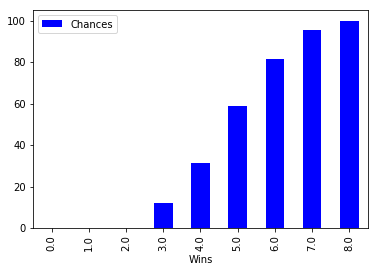

In [67]:
midseason_playoff_chances.plot('Wins', 'Chances', kind='bar', color='b')

In [68]:
# This too. This is for the end of the season. 
for i in range(0, 17):
    print i, playoff_chances((i, 16-i))

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 1.96078431373
8 10.1694915254
9 37.5
10 82.3529411765
11 97.3684210526
12 100.0
13 100.0
14 100.0
15 100.0
16 100.0


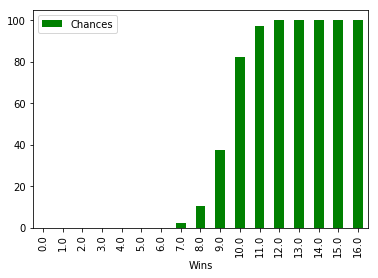

In [69]:
# Making a dataframe to that effect. 

final_playoff_chances = pd.DataFrame([[i for i in range(17)], [playoff_chances((i, 16-i)) for i in range(17)]])

final_playoff_chances = final_playoff_chances.T
final_playoff_chances.rename({0: 'Wins', 1: 'Chances'}, axis=1, inplace=True)

final_playoff_chances.plot('Wins', 'Chances', kind='bar', color='g')

Now to make a dictionary of 'draft standings.' This was necessary because teams sometimes trade their picks. 
It's possible that original draft position is more important than the eventual pick. 

In [70]:
# Initial dictionary of draft standings. Will be adjusted
draft_standings_dict = {}
for season in all_seasons:
    draft_standings_dict[season] = playoff_dict[season]

In [71]:
# This is the first adjustment. There will be another. 
for season in seasons:
    draft_standings_dict[season] = {conference: pd.read_excel('../Datasets/Draft_Standings(2002-2017)/{}{}.xlsx'.format(conference, season))\
                            for conference in ['AFC', 'NFC']}

In [72]:
# This may be the piece de resistance.  
# (Spoiler alert: it's not. See below. )
for season in all_seasons:
    draft_standings_dict[season] = pd.concat([draft_standings_dict[season]['AFC'], draft_standings_dict[season]['NFC']], axis=0)\
    .reset_index(drop=True).sort_values(['W', 'SoS']).reset_index(drop=True)

In [73]:
for season in all_seasons:
    draft_standings_dict[season]['Pick'] = [i+1 for i in range(len(draft_standings_dict[season]))]    

In [74]:
for season in all_seasons:
    draft_standings_dict[season] = draft_standings_dict[season][[u'Pick',  u'Tm',    u'W',    u'L', u'W-L%',   u'PF',   u'PA',   u'PD',  u'MoV',
        u'SoS',  u'SRS', u'OSRS', u'DSRS']]

In [75]:
for season in all_seasons:
    draft_standings_dict[season]['Playoffs'] = draft_standings_dict[season]['Tm'].apply(lambda x: True if ('*' or '+') in x else False)   

In [76]:
# Making the final adjustment (I may have lied about the piece de resistance earlier).
for season in all_seasons:
    draft_standings_dict[season] = draft_standings_dict[season].sort_values(['Playoffs', 'W', 'SoS'])

Now to create a table that gives expected draft position by previous win total. 

In [79]:
super_list = []
for i in range(17):
    dumb_list = []
    for season in all_seasons:
        for value in draft_standings_dict[season][draft_standings_dict[season]['W'] == i]['Pick'].values:
            dumb_list.append(value)
    super_list.append(dumb_list)

In [80]:
avg_list = []
for dumb_list in super_list:
    avg_list.append(np.mean(dumb_list))
    

In [81]:
draft_pos_by_wins = pd.Series(avg_list, index=[i for i in range(17)])

In [83]:
# Another important Series. 
# Expected draft position by win total. 
draft_pos_by_wins

0      1.000000
1      1.090909
2      1.558824
3      2.674419
4      4.421053
5      6.838384
6      9.378378
7     11.903704
8     15.568493
9     18.985612
10    22.325758
11    25.099010
12    27.886076
13    29.717391
14    29.600000
15    30.333333
16    32.000000
dtype: float64

In [84]:
# Turning it into a DataFrame

draft_pos_by_wins = pd.DataFrame([[i for i in range(17)], avg_list])

draft_pos_by_wins = draft_pos_by_wins.T
draft_pos_by_wins.rename({0: 'Wins', 1: 'Expected_Pick'}, axis=1, inplace=True)

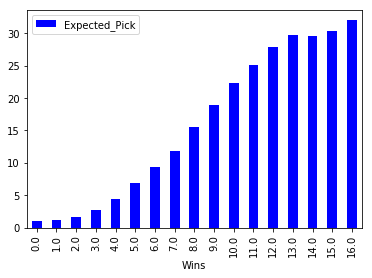

In [85]:
draft_pos_by_wins.plot('Wins', 'Expected_Pick', kind='bar', color='b')

In [88]:
# Decided to dispense with the hierarchical index. 
full_df = full_df.reset_index()

In [89]:
# Setting up for a linear regression. 

X = full_df.loc[1:, [u'5_yrs_prev', u'4_yrs_prev', u'3_yrs_prev', u'2_yrs_prev',
       u'1_yr_prev', u'prev_win_tot', 'pick']]

y = full_df.loc[1:, 'expd(5)']

/opt/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.
/opt/lib/python2.7/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [91]:
# Dropping null values where necessary (basically rows where there was no information).
full_df = full_df.dropna(thresh=9)

In [92]:
full_df = full_df[full_df['prev_win_tot'].isnull() == False]

In [93]:
full_df = full_df.dropna()

In [94]:
# This makes the train-test-split easier
full_df['Year'] = full_df['Year'].apply(lambda x: int(x))

In [95]:
train_data = full_df[full_df['Year'] < 2002]

In [96]:
test_data =  full_df[full_df['Year'] >= 2002]

In [97]:
X_train = train_data[[u'5_yrs_prev', u'4_yrs_prev', u'3_yrs_prev', u'2_yrs_prev',
       u'1_yr_prev', u'prev_win_tot', 'Pick']]

X_test = test_data[[u'5_yrs_prev', u'4_yrs_prev', u'3_yrs_prev', u'2_yrs_prev',
       u'1_yr_prev', u'prev_win_tot', 'Pick']]

y_train = train_data['expd(5)']
y_test = test_data['expd(5)']

In [98]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.fit_transform(X_test)

In [99]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(Xs_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [102]:
# A small R^2. The linear regression doesn't hurt but it barely helps. 
linreg.score(Xs_test, y_test)

0.091730073302670911

In [103]:
linreg.coef_

array([ 0.02921867, -0.01028453, -0.0718125 , -0.02029698,  0.06642093,
        0.22887092,  0.15412322])

In [104]:
y_pred = linreg.predict(Xs_test)

In [106]:
# Stacking predicted against actual. 
pd.DataFrame([y_pred, y_test]).T

,0,1
0,1.152507,1.298377
1,1.393373,3.450379
2,1.131193,0.140911
3,1.248207,0.578390
4,1.131182,0.203390
5,1.150740,1.032508
6,1.004562,0.843137
7,1.041016,0.058824
8,1.282439,2.039216
9,1.090526,3.124442


In [108]:
# Bringing back the multi-index
full_df.set_index(['Pick', 'Year'])

index   Tm  5_yrs_prev  4_yrs_prev  3_yrs_prev  2_yrs_prev  \
Pick Year                                                               
1    1979      1  BUF        99.0        99.0        99.0        99.0   
     1980      2  DET        99.0        99.0        99.0        11.0   
     1981      3  NOS        99.0        99.0         3.0        11.0   
     1982      4  NEP        99.0        18.0        25.0        14.0   
     1983      5  IND        25.0         6.0         5.0        12.0   
     1984      6  NEP        25.0        14.0        19.0         1.0   
     1985      7  BUF        16.0        28.0        19.0        12.0   
     1986      8  TBB         7.0        17.0        99.0        99.0   
     1987      9  TBB        17.0        99.0        99.0         8.0   
     1988     10  ATL        16.0         9.0         2.0         2.0   
     1989     11  DAL        25.0        17.0        18.0        12.0   
     1990     12  IND         5.0         4.0         2.0        99.0   
     1991     13  DAL        18.0        12.0        11.0         1.0   
     1992     14  IND         2.0        99.0        22.0         1.0   
     1993     15  NEP        17.0        16.0         8.0        11.0   
     1994     16  CIN        99.0        12.0        18.0         6.0   
     1995     17  CIN        12.0        18.0         6.0         5.0   
     1996     18  NYJ        99.0        15.0         4.0        12.0   
     1997     19  LAR         3.0        10.0        15.0         6.0   
     1998     20  IND        16.0         2.0        15.0        19.0   
     2000     22  CLE        99.0        99.0        99.0        99.0   
     2001     23  ATL        99.0        11.0        12.0        30.0   
     2003     25  CIN        13.0         3.0         4.0         4.0   
     2004     26  LAC        99.0        99.0         5.0         5.0   
     2005     27  SFF        16.0         7.0        27.0        26.0   
     2006     28  HOU        99.0         1.0         3.0        10.0   
     2007     29  OAK        17.0        31.0         2.0        23.0   
     2008     30  MIA        99.0        19.0         2.0        16.0   
     2009     31  DET         7.0        10.0         9.0         2.0   
     2010     32  LAR        19.0        15.0        13.0         2.0   
...          ...  ...         ...         ...         ...         ...   
30   2012   1194  SFF        11.0        29.0        10.0        11.0   
     2013   1195  LAR         2.0         2.0         1.0        14.0   
31   1995   1217  KCC        13.0        21.0        20.0        99.0   
     1999   1221  DEN        99.0        99.0        15.0        28.0   
     2000   1222  LAR         6.0         6.0         1.0         6.0   
     2001   1223  BAL         4.0         4.0        10.0        10.0   
     2002   1224  LAR         1.0         6.0         6.0        31.0   
     2003   1225  OAK         4.0        18.0        17.0        28.0   
     2004   1226  SFF        24.0        16.0         7.0        27.0   
     2005   1227  PHI         6.0        25.0        26.0        15.0   
     2006   1228  SEA         9.0        28.0        11.0        23.0   
     2007   1229  CHI        29.0        14.0        14.0         4.0   
     2008   1230  NYG        25.0         4.0        99.0        32.0   
     2009   1231  ARI         3.0         8.0        10.0         5.0   
     2010   1232  IND        29.0        30.0        32.0        99.0   
     2011   1233  PIT        25.0        15.0        23.0        32.0   
     2012   1234  TBB         4.0        20.0        17.0         3.0   
     2013   1235  DAL        22.0        99.0        24.0         9.0   
32   1995   1257  GBP        18.0        19.0         5.0        15.0   
     2002   1264  WAS        17.0        99.0         7.0         2.0   
     2003   1265  OAK         4.0        18.0        17.0        28.0   
     2004   1266  NEP        17.0        99.0         6.0        21.0

Creating a chart that shows expected times a team with a given pick will reach the playoffs in the next 5 years. 

In [113]:
expd5_by_pick = full_df.groupby('Pick')['expd(5)'].mean()

In [114]:
expd5_by_pick = list(expd5_by_pick.values)

In [115]:
expd5_by_pick = pd.DataFrame([[i for i in range(1,33)], expd5_by_pick])

expd5_by_pick = expd5_by_pick.T
expd5_by_pick.rename({0: 'Pick', 1: 'Expd._Plyfs_5_yrs'}, axis=1, inplace=True)



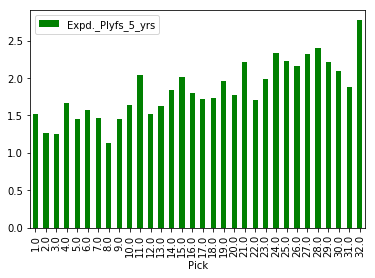

In [116]:
expd5_by_pick.plot('Pick', 'Expd._Plyfs_5_yrs', kind='bar', color='g')

In [118]:
# Linear Regression didn't impress. Trying a decision tree. 

from sklearn.tree import DecisionTreeRegressor

In [119]:
dtr = DecisionTreeRegressor()

In [120]:
dtr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [122]:
# A negative score. Ouch. 
dtr.score(X_test, y_test)

-0.80661820487483671

In [123]:
# If one tree won't cut it, perhaps an entire forest. 
from sklearn.ensemble import RandomForestRegressor

In [160]:
rfr = RandomForestRegressor(n_estimators=100, max_features=3)

In [161]:
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [162]:
# The random forest does little more than the linear regression. 
rfr.score(X_test, y_test)

0.01123137999614543

 Now we're going to make a DataFrame to facilitate TimeSeries modeling. 

In [127]:
for season in seasons:
    draft_standings_dict[season]['Tm'] = draft_standings_dict[season]['Tm'].apply(team_abbreviator)

In [128]:
all_win_totals = []
for team in teams:
    team_win_totals = []
    for season in all_seasons:
        try:
            team_win_totals.append(win_total(season, team))
        except:
            team_win_totals.append(np.NaN)
    all_win_totals.append(team_win_totals)

In [129]:
win_totals_df = pd.DataFrame(all_win_totals, index=teams, columns=all_seasons).T

In [130]:
all_orig_draft_spots = []
for team in teams:
    team_orig_draft_spots = []
    for season in all_seasons:
        try:
            team_orig_draft_spots.append(draft_standings_dict[season][draft_standings_dict[season]['Tm'] == team.upper()]['Pick'].values[0])
        except:
            team_orig_draft_spots.append(np.NaN)
            
    all_orig_draft_spots.append(team_orig_draft_spots)

In [131]:
orig_draft_spots_df = pd.DataFrame(all_orig_draft_spots, index=teams, columns=all_seasons).T
orig_draft_spots_df

,nyj,nep,mia,buf,pit,bal,cle,cin,ind,jax,ten,hou,lac,oak,kcc,den,nyg,phi,was,dal,min,gbp,det,chi,tbb,atl,nos,car,lar,sea,ari,sff
1978,16.0,25.0,24.0,5.0,28.0,12.0,NaN,2.0,6.0,NaN,23.0,NaN,19.0,20.0,3.0,22.0,7.0,21.0,13.0,27.0,14.0,15.0,9.0,10.0,4.0,17.0,11.0,NaN,26.0,18.0,8.0,1.0
1979,13.0,15.0,21.0,10.0,28.0,18.0,NaN,3.0,6.0,NaN,26.0,NaN,27.0,16.0,11.0,23.0,8.0,24.0,22.0,25.0,9.0,4.0,1.0,20.0,19.0,7.0,12.0,NaN,14.0,17.0,5.0,2.0
1980,2.0,19.0,14.0,23.0,18.0,21.0,NaN,9.0,12.0,NaN,22.0,NaN,24.0,25.0,13.0,15.0,3.0,28.0,10.0,26.0,17.0,6.0,16.0,11.0,5.0,27.0,1.0,NaN,20.0,4.0,7.0,8.0
1981,20.0,1.0,25.0,22.0,13.0,4.0,NaN,26.0,2.0,NaN,9.0,NaN,21.0,10.0,17.0,23.0,19.0,24.0,16.0,27.0,11.0,15.0,14.0,7.0,18.0,8.0,3.0,NaN,5.0,6.0,12.0,28.0
1982,24.0,16.0,26.0,14.0,22.0,13.0,NaN,25.0,1.0,NaN,2.0,NaN,21.0,27.0,7.0,4.0,11.0,8.0,28.0,23.0,19.0,17.0,12.0,6.0,20.0,15.0,10.0,NaN,3.0,9.0,18.0,5.0
1983,9.0,14.0,25.0,15.0,23.0,18.0,NaN,7.0,8.0,NaN,1.0,NaN,6.0,26.0,5.0,20.0,3.0,4.0,28.0,27.0,13.0,12.0,19.0,11.0,2.0,10.0,16.0,NaN,22.0,21.0,17.0,24.0
1984,10.0,17.0,27.0,1.0,16.0,7.0,NaN,13.0,5.0,NaN,2.0,NaN,12.0,24.0,15.0,26.0,19.0,9.0,23.0,20.0,3.0,14.0,6.0,21.0,8.0,4.0,11.0,NaN,22.0,25.0,18.0,28.0
1985,24.0,25.0,26.0,1.0,9.0,15.0,NaN,11.0,7.0,NaN,5.0,NaN,14.0,27.0,8.0,23.0,18.0,10.0,20.0,19.0,12.0,16.0,13.0,28.0,2.0,3.0,6.0,NaN,22.0,17.0,4.0,21.0
1986,20.0,23.0,14.0,3.0,10.0,25.0,NaN,21.0,2.0,NaN,8.0,NaN,6.0,15.0,17.0,24.0,28.0,9.0,26.0,13.0,16.0,5.0,7.0,27.0,1.0,11.0,12.0,NaN,19.0,22.0,4.0,18.0
1987,8.0,18.0,16.0,14.0,19.0,24.0,NaN,5.0,21.0,NaN,22.0,NaN,17.0,6.0,4.0,23.0,10.0,13.0,25.0,11.0,15.0,7.0,2.0,26.0,3.0,1.0,27.0,NaN,9.0,20.0,12.0,28.0


In [132]:
all_first_picks = []
for team in teams:
    team_first_picks = []
    for season in all_seasons:
        try:
            team_first_picks.append(reset_draft_dict[season]\
                                    [reset_draft_dict[season]['Tm'] == team.upper()]['Pick'].values[0])
        except:
            team_first_picks.append(np.NaN)
    
    all_first_picks.append(team_first_picks)

In [133]:
first_picks_df = pd.DataFrame(all_first_picks, index=teams, columns=all_seasons).T

In [134]:
first_picks_df

,nyj,nep,mia,buf,pit,bal,cle,cin,ind,jax,ten,hou,lac,oak,kcc,den,nyg,phi,was,dal,min,gbp,det,chi,tbb,atl,nos,car,lar,sea,ari,sff
1978,4.0,18.0,NaN,5.0,22.0,12.0,NaN,8.0,25.0,NaN,1.0,NaN,14.0,NaN,2.0,27.0,10.0,NaN,NaN,28.0,21.0,6.0,11.0,NaN,17.0,13.0,3.0,NaN,20.0,9.0,15.0,7.0
1979,14.0,25.0,24.0,1.0,28.0,20.0,NaN,3.0,6.0,NaN,NaN,NaN,13.0,NaN,2.0,22.0,7.0,21.0,NaN,27.0,16.0,15.0,10.0,4.0,NaN,17.0,11.0,NaN,19.0,18.0,8.0,NaN
1980,2.0,14.0,21.0,16.0,28.0,27.0,NaN,3.0,5.0,NaN,NaN,NaN,NaN,15.0,11.0,NaN,8.0,23.0,18.0,NaN,9.0,4.0,1.0,19.0,22.0,7.0,12.0,NaN,17.0,10.0,6.0,13.0
1981,3.0,19.0,13.0,28.0,17.0,22.0,NaN,10.0,12.0,NaN,NaN,NaN,24.0,21.0,14.0,15.0,2.0,27.0,20.0,26.0,NaN,6.0,16.0,11.0,7.0,25.0,1.0,NaN,9.0,4.0,5.0,8.0
1982,23.0,1.0,24.0,19.0,12.0,3.0,NaN,26.0,2.0,NaN,8.0,NaN,NaN,10.0,11.0,21.0,18.0,20.0,NaN,25.0,7.0,22.0,15.0,5.0,17.0,9.0,13.0,NaN,14.0,6.0,16.0,NaN
1983,24.0,15.0,27.0,12.0,21.0,NaN,NaN,25.0,1.0,NaN,9.0,NaN,5.0,26.0,7.0,4.0,10.0,8.0,28.0,23.0,19.0,11.0,13.0,6.0,NaN,16.0,NaN,NaN,2.0,3.0,17.0,NaN
1984,10.0,1.0,14.0,26.0,23.0,18.0,NaN,7.0,8.0,NaN,2.0,NaN,6.0,NaN,5.0,NaN,3.0,4.0,NaN,25.0,13.0,12.0,20.0,11.0,NaN,9.0,NaN,NaN,NaN,22.0,17.0,24.0
1985,10.0,28.0,27.0,1.0,20.0,NaN,NaN,13.0,5.0,NaN,3.0,NaN,12.0,23.0,15.0,26.0,19.0,9.0,NaN,17.0,4.0,7.0,6.0,22.0,8.0,2.0,24.0,NaN,21.0,NaN,18.0,16.0
1986,22.0,26.0,NaN,16.0,9.0,NaN,NaN,11.0,4.0,NaN,3.0,NaN,8.0,24.0,7.0,NaN,19.0,10.0,NaN,18.0,14.0,NaN,12.0,27.0,1.0,2.0,6.0,NaN,23.0,15.0,5.0,NaN
1987,21.0,23.0,16.0,8.0,10.0,5.0,NaN,17.0,2.0,NaN,3.0,NaN,24.0,15.0,19.0,27.0,28.0,9.0,NaN,12.0,14.0,4.0,7.0,26.0,1.0,13.0,11.0,NaN,NaN,18.0,6.0,22.0


In [135]:
pd.DataFrame(data=[df['nyj'] for df in [orig_draft_spots_df, first_picks_df, win_totals_df]],\
             index=['orig_draft_spot', 'team_first_pick', 'win_total']).T

,orig_draft_spot,team_first_pick,win_total
1978,16.0,4.0,8.000000
1979,13.0,14.0,8.000000
1980,2.0,2.0,4.000000
1981,20.0,3.0,10.000000
1982,24.0,23.0,10.666667
1983,9.0,24.0,7.000000
1984,10.0,10.0,7.000000
1985,24.0,10.0,11.000000
1986,20.0,22.0,10.000000
1987,8.0,21.0,6.400000


In [136]:
TimeSeries_dict = {}
for team in teams:
    TimeSeries_dict[team] = pd.DataFrame(data=[df[team] for df in [orig_draft_spots_df, first_picks_df, win_totals_df]],\
             index=['orig_draft_spot', 'team_first_pick', 'adj_win_total']).T

In [137]:
for team in teams:
    TimeSeries_dict[team] = TimeSeries_dict[team].dropna(how='all')

In [138]:
for team in teams:
    TimeSeries_dict[team]['team_first_pick'] =  TimeSeries_dict[team]['team_first_pick'].fillna(48)

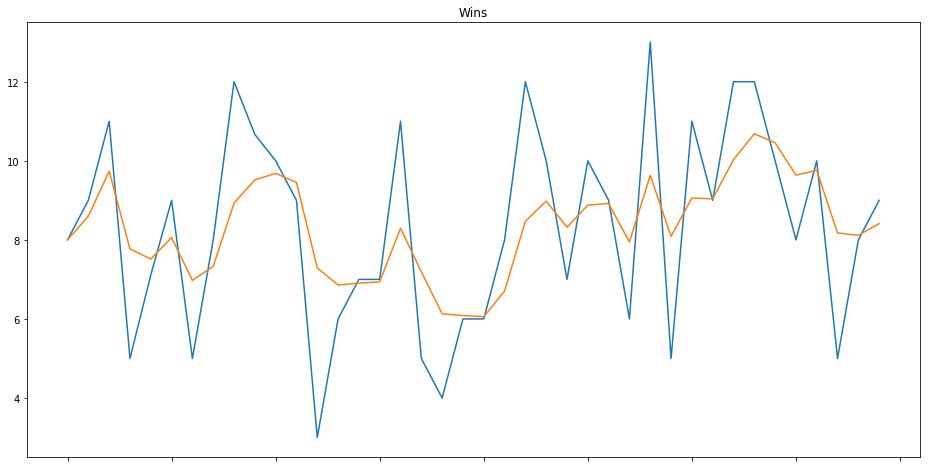

In [139]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title('Wins')
TimeSeries_dict['bal']['adj_win_total'].plot()

TimeSeries_dict['bal']['adj_win_total'].ewm(span=5).mean().plot()

In [140]:
TimeSeries_dict['bal']['Prev_adj_win_tot'] = TimeSeries_dict['bal']['adj_win_total'].shift(1)

In [141]:
TimeSeries_dict['bal']['improved'] = np.where(TimeSeries_dict['bal']['adj_win_total'] > TimeSeries_dict['bal']['adj_win_total'] .shift(1), 1, 0)

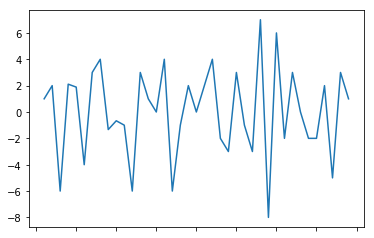

In [142]:
TimeSeries_dict['bal']['adj_win_total'].diff().plot()

In [143]:
print TimeSeries_dict['bal']['adj_win_total'].autocorr(lag=1)
print TimeSeries_dict['bal']['adj_win_total'].autocorr(lag=2)
print TimeSeries_dict['bal']['adj_win_total'].autocorr(lag=3)
print TimeSeries_dict['bal']['adj_win_total'].autocorr(lag=4)
print TimeSeries_dict['bal']['adj_win_total'].autocorr(lag=5)
print TimeSeries_dict['bal']['adj_win_total'].autocorr(lag=6)

0.0874905315062
0.0839807236924
0.0301863769896
-0.317692382616
-0.0756815989276
0.288438915241


In [144]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

/opt/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


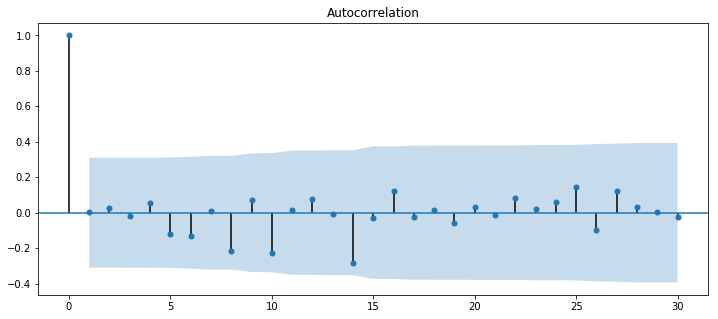

In [145]:
fig, ax = plt.subplots(figsize=(12,5))

plot_acf(TimeSeries_dict['nyj']['adj_win_total'], lags=30, ax=ax)
plt.show()

In [146]:
full_acf_list = []
for team in teams:
    team_acf_list = []
    for i in range(10):
        team_acf_list.append(TimeSeries_dict[team]['adj_win_total'].autocorr(lag=i))
    full_acf_list.append(team_acf_list)

In [147]:
acf_df = pd.DataFrame(full_acf_list, index=[teams]).T
acf_df

,nyj,nep,mia,buf,pit,bal,cle,cin,ind,jax,ten,hou,lac,oak,kcc,den,nyg,phi,was,dal,min,gbp,det,chi,tbb,atl,nos,car,lar,sea,ari,sff
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.006204,0.520609,0.244030,0.476555,0.143683,0.087491,0.205554,0.195644,0.403194,0.422949,0.426562,-0.086089,0.267152,0.495716,0.244193,0.098641,0.016085,0.378447,0.383875,0.347047,0.087981,0.451662,0.074351,0.327040,0.122761,0.081853,0.259353,-0.101869,0.317574,0.419542,0.290456,0.496092
2,0.027039,0.473723,0.310310,0.267880,-0.131294,0.083981,-0.068129,0.189787,0.241921,0.284522,0.056205,-0.095752,0.313656,0.319850,0.112654,0.026613,-0.015191,-0.057581,0.104168,0.353755,-0.066749,0.266283,0.186363,0.220856,0.374205,0.038266,0.213984,0.007179,0.300710,0.259703,0.155299,0.229230
3,-0.019842,0.420523,0.316537,0.103380,0.229226,0.030186,-0.275755,-0.237699,0.288399,0.013006,-0.039551,0.251087,0.235900,0.117772,0.078302,-0.281591,0.116324,-0.138628,0.161279,-0.044280,-0.072110,0.181573,0.141193,-0.029472,0.431611,0.035642,0.073319,0.018498,0.083958,-0.129632,-0.033324,0.215021
4,0.059425,0.189260,-0.038376,-0.076460,0.070377,-0.317692,0.058534,0.009023,0.362836,-0.243933,-0.135342,0.242128,-0.163498,-0.008297,0.050951,-0.323013,0.189737,-0.083635,0.256855,-0.159561,-0.183864,0.078769,0.124327,-0.038722,-0.117277,0.218928,0.049453,-0.081950,0.062578,-0.235601,0.018330,0.139318
5,-0.132848,0.213235,0.173485,-0.121362,-0.129683,-0.075682,0.389522,-0.246610,0.286415,-0.087689,-0.284942,-0.125285,-0.033109,0.117280,-0.027199,-0.253874,-0.036197,-0.356223,0.283363,-0.305444,0.115870,0.138359,-0.104383,0.128027,0.313357,-0.176159,-0.050934,-0.388378,-0.058407,-0.380016,0.163491,0.108545
6,-0.145643,0.226143,0.069091,-0.171013,-0.051626,0.288439,0.052806,0.173224,0.197609,0.135705,-0.366452,-0.510479,-0.482536,0.188955,-0.073304,-0.197421,-0.459313,-0.348790,0.036553,-0.555286,0.099165,-0.088033,-0.044250,-0.093340,0.008871,0.246008,-0.154721,0.035372,-0.245197,-0.183491,0.324807,0.071227
7,0.014590,0.230191,0.103733,-0.030821,0.083589,0.000451,0.115469,0.036632,0.243786,0.037428,-0.223682,-0.121854,-0.195627,0.150994,-0.123662,0.255518,-0.216325,-0.083381,0.124331,-0.329491,-0.100808,0.061655,-0.136314,-0.078681,-0.156811,0.218224,-0.284463,-0.183875,-0.183795,-0.076050,0.045511,-0.047533
8,-0.259259,0.311763,0.408149,0.045594,-0.232535,0.136406,-0.293545,0.315508,-0.017885,0.363368,0.030262,0.406658,-0.284434,0.354153,-0.145260,0.101235,0.106892,-0.080422,0.286766,-0.341715,-0.246351,0.069923,-0.178998,-0.309735,0.173578,-0.008179,-0.133248,-0.104409,-0.463386,0.076944,-0.109463,-0.008990
9,0.089821,0.385977,0.000970,-0.051654,-0.137169,-0.056205,-0.130101,0.050341,0.112730,-0.161708,0.128027,-0.517428,-0.416133,0.317847,-0.196368,0.161721,-0.194120,-0.150686,0.184139,-0.122452,0.131516,-0.096653,-0.236233,-0.207962,-0.280200,-0.343764,0.039105,0.506011,-0.270232,0.092513,-0.190862,-0.058952


In [148]:
for i in range(10):
    print acf_df.iloc[i].mean(), '     ', acf_df.iloc[i].std()

1.0       8.91752592772e-17
0.253260535598       0.17721745095
0.155732710916       0.15742201453
0.0700266104266       0.179987232251
-0.000824784325917       0.1703202157
-0.0294836032491       0.213459362878
-0.0630287710201       0.242556734838
-0.0265960166804       0.158485438686
-0.000956807213069       0.242950444695
-0.0505676413355       0.226612009443


In [149]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

nyj


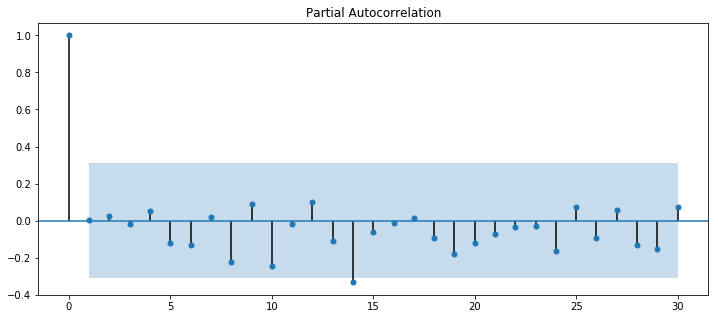

nep


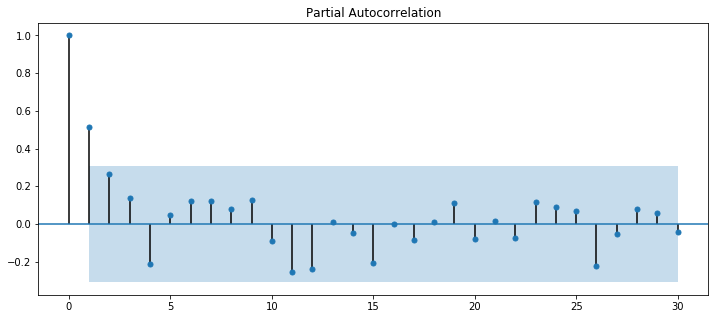

mia


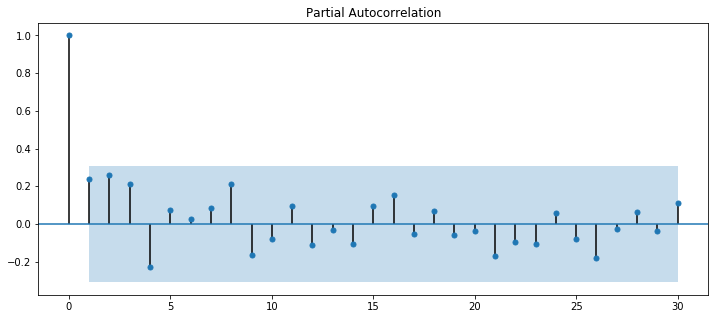

buf


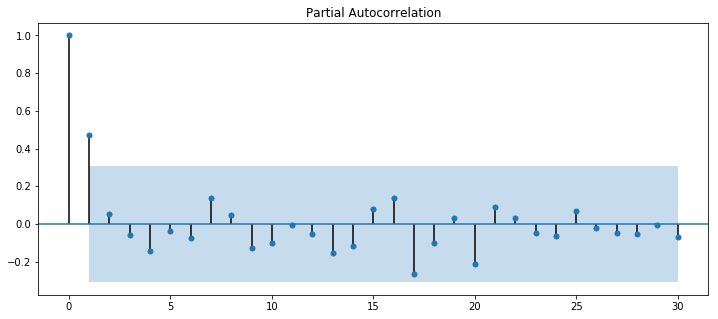

pit


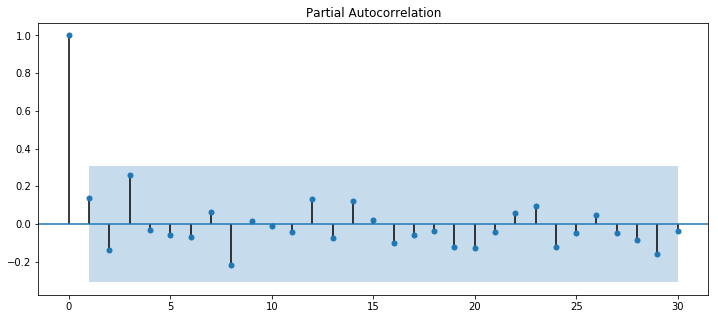

bal


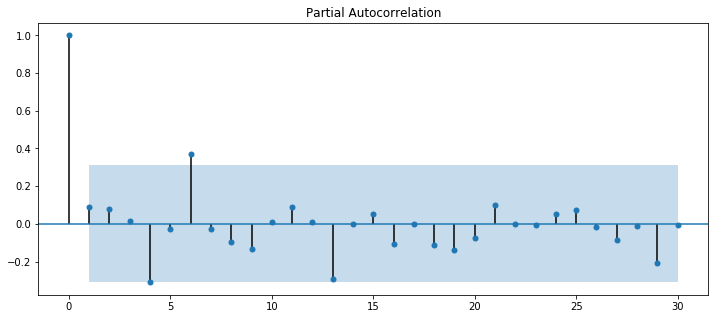

cle


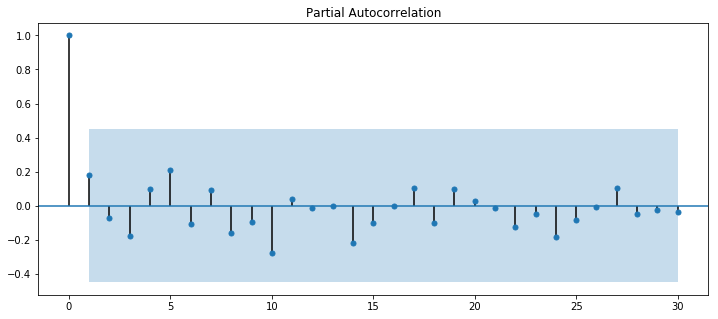

cin


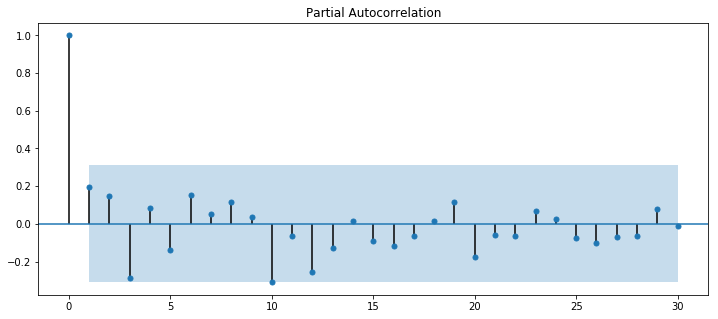

ind


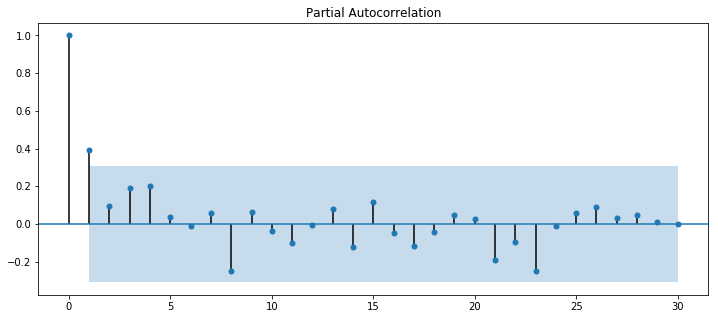

jax


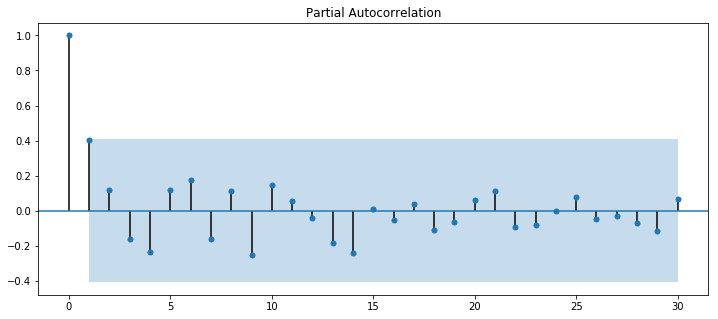

ten


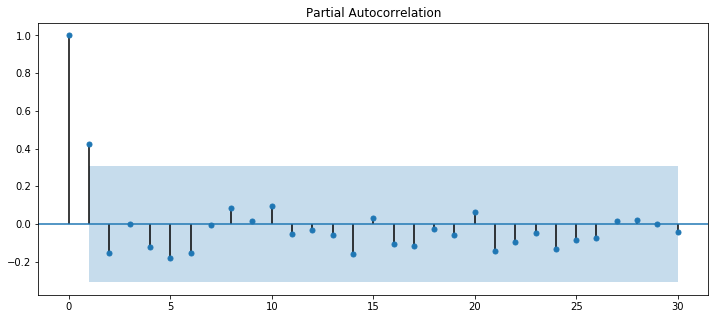

hou


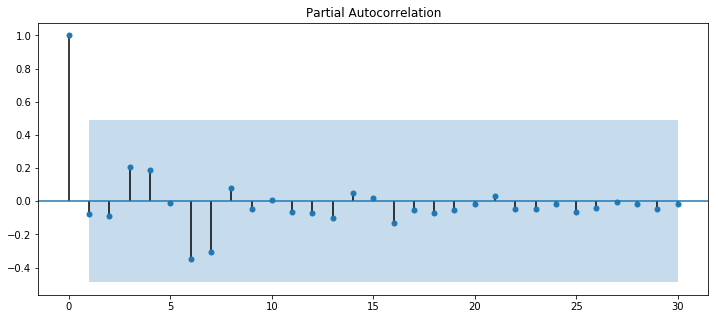

lac


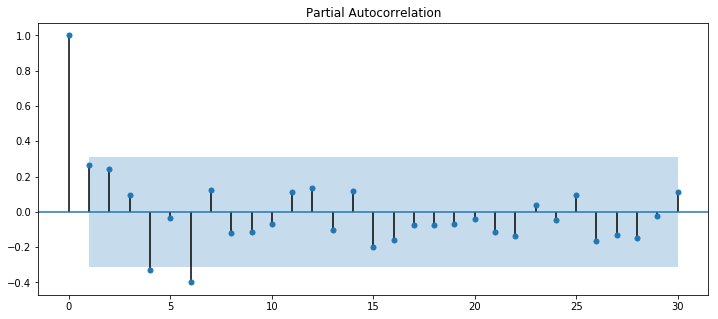

oak


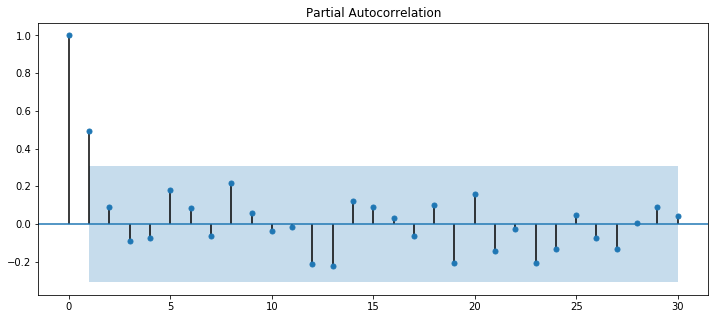

kcc


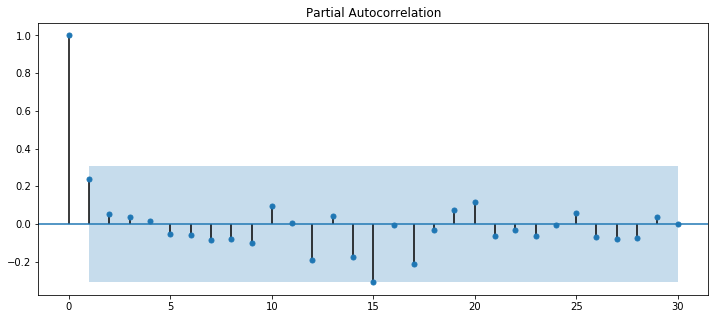

den


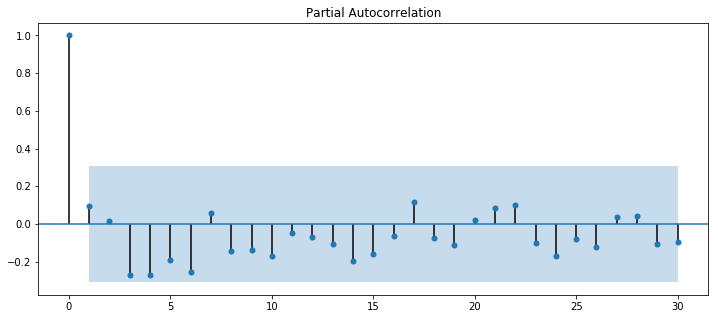

nyg


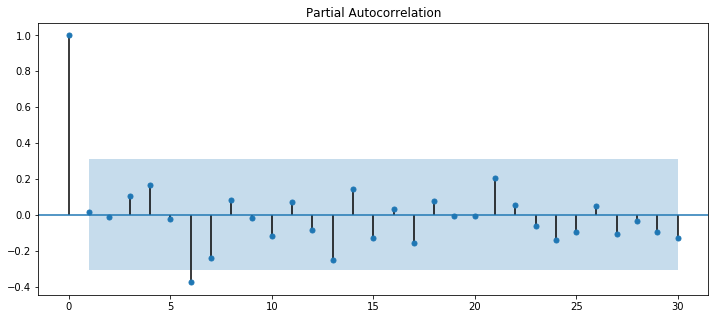

phi


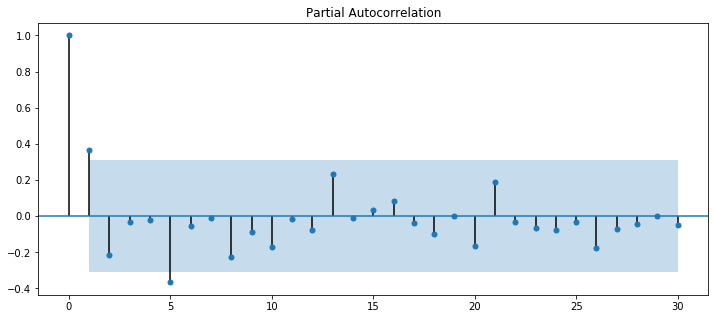

was


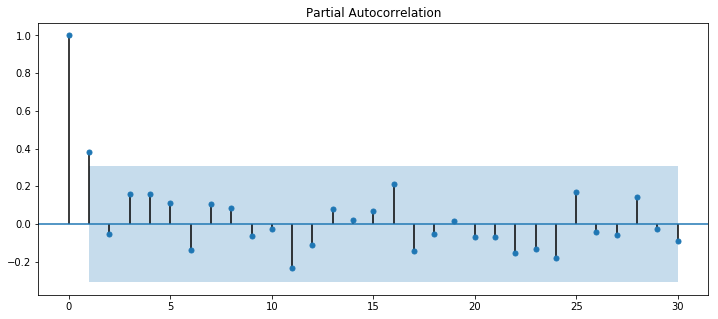

dal


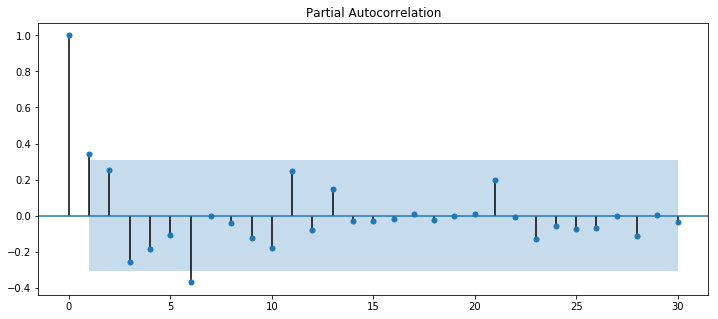

min


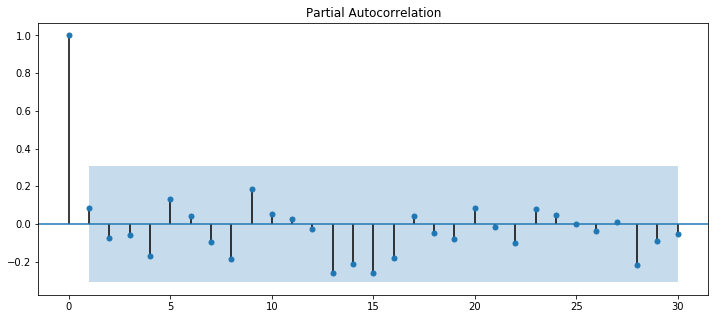

gbp


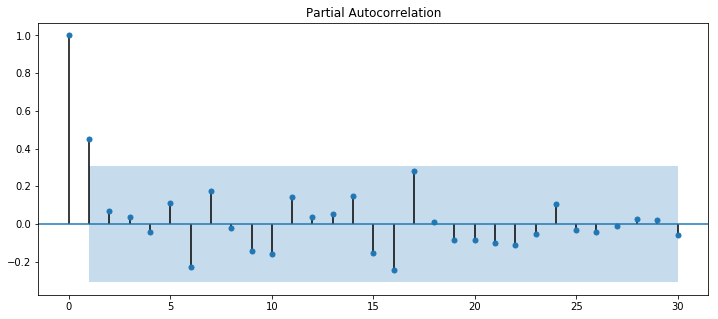

det


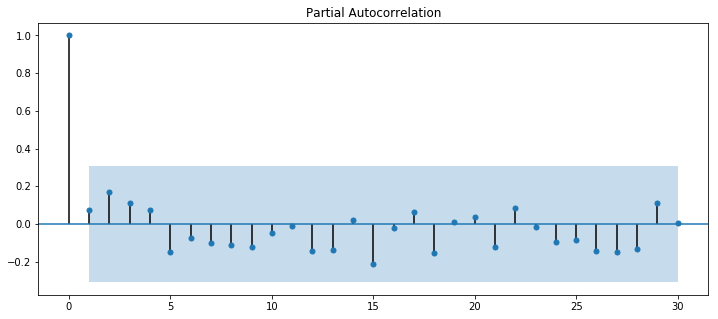

chi


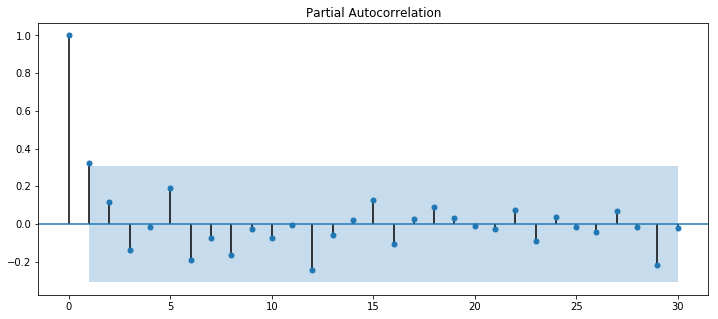

tbb


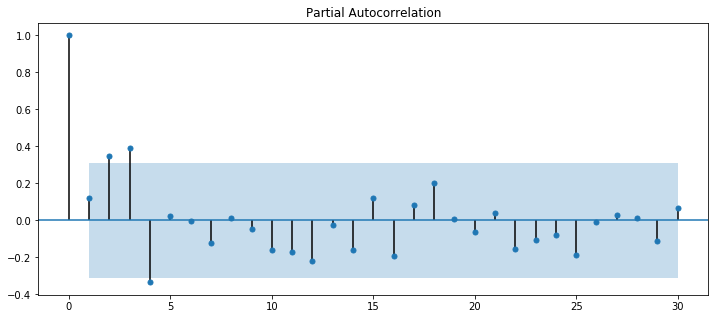

atl


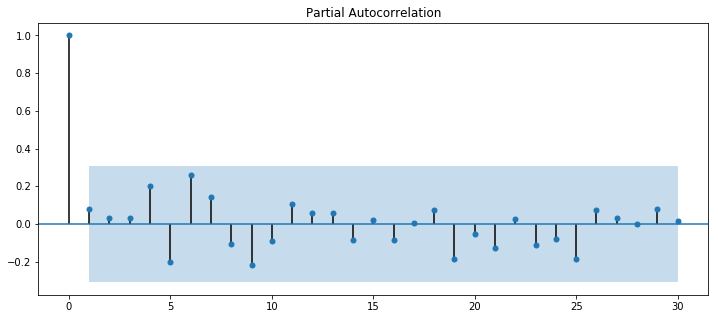

nos


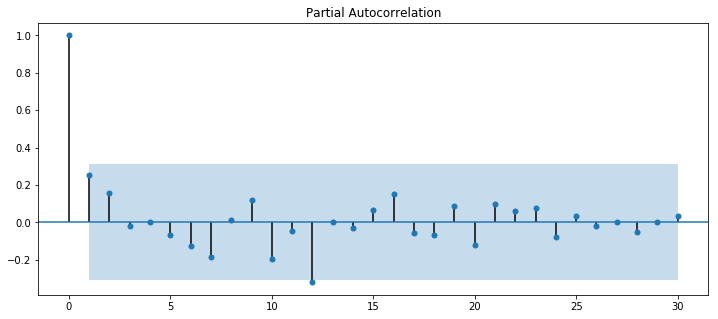

car


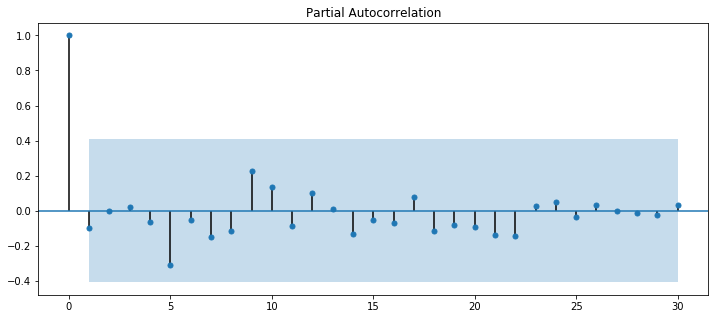

lar


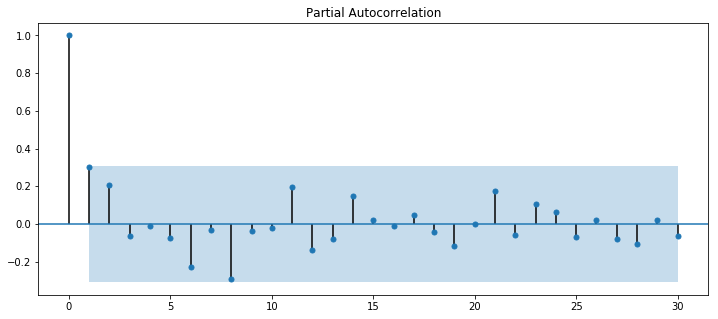

sea


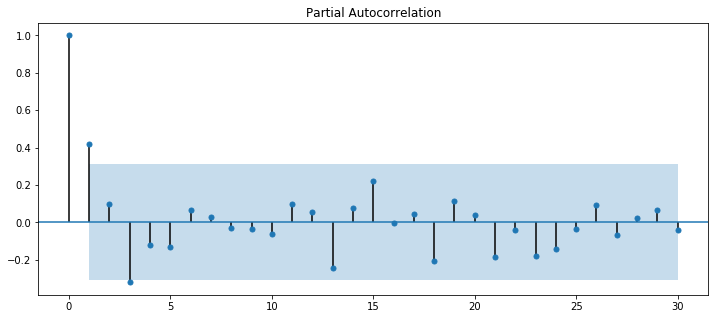

ari


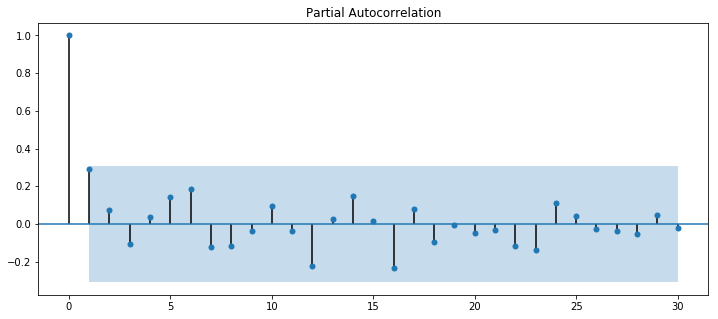

sff


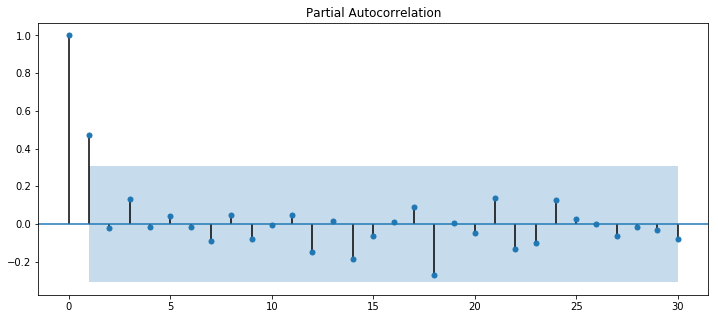

In [150]:
for team in teams:
    print team
    fig, ax = plt.subplots(figsize=(12,5))
    ax.set_title(team)
    plot_pacf(TimeSeries_dict[team]['adj_win_total'], lags=30, ax=ax)
    plt.show()

In [152]:
from statsmodels.tsa.arima_model import ARIMA

In [153]:
arima = ARIMA(endog=TimeSeries_dict['bal']['adj_win_total'], order=(2,1,2))

In [154]:
results_ARIMA = arima.fit() 

In [156]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA_diff

1979    0.035802
1980   -0.416622
1981   -1.422321
1982    3.003035
1983    0.754528
1984   -0.510898
1985    2.495796
1986   -0.050406
1987   -3.228181
1988   -1.700332
1989   -1.094755
1990   -0.042625
1991    4.857868
1992    2.037058
1993    1.157814
1994    1.078601
1995   -2.305118
1996    2.998641
1997    3.562681
1998    1.853323
1999    1.692002
2000    0.034859
2001   -3.443997
2002   -1.409020
2003    1.101291
2004   -1.390024
2005   -0.498850
2006    2.192163
2007   -4.019549
2008    3.303118
2009   -2.326041
2010   -0.053209
2011   -3.086656
2012   -2.471738
2013   -1.108309
2014    1.147689
2015   -1.070233
2016    3.856260
2017    0.601957
dtype: float64


In [157]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()

1979    0.035802
1980   -0.380820
1981   -1.803141
1982    1.199895
1983    1.954423
dtype: float64


In [158]:
results_ARIMA.summary()

/opt/lib/python2.7/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/opt/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:        D.adj_win_total   No. Observations:                   39
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 -92.661
Method:                       css-mle   S.D. of innovations              2.469
Date:                Mon, 19 Feb 2018   AIC                            197.321
Time:                        15:25:54   BIC                            207.302
Sample:                    01-01-1979   HQIC                           200.902
                         - 01-01-2017                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0358      0.038      0.947      0.350      -0.038       0.110
ar.L1.D.adj_win_total    -0.8871        nan        nan        nan         nan         nan
ar.L2.D.adj_win_total     0.1128        nan        nan        nan         nan         nan
ma.L1.D.adj_win_total    -0.0015      0.077     -0.019      0.985      -0.152       0.149
ma.L2.D.adj_win_total    -0.9985      0.077    -13.044      0.000      -1.149      -0.848
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0000           +0.0000j            1.0000            0.5000
AR.2            8.8635           +0.0000j            8.8635            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.0015           +0.0000j            1.0015            0.5000
-----------------------------------------------------------------------------
"""

In [159]:
# At this point I was running out of time. 
#Sadly, I have not yet been able to draw any findings from the TimeSeries models.